# Imports

In [ ]:
import json
import os
import pickle
import random
import sys
import traceback

import cv2
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from tqdm import tqdm

from original_utils import (
    PreProcessing,
    create_bright_reference,
    histogram_match_images,
    plot_histograms,
)


/Users/martin/anaconda3/envs/sam2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#need to install the sam2 repo to use the sam2 model
#!git clone -q https://github.com/facebookresearch/sam2.git

In [ ]:
sam2_repo_path = os.path.abspath('sam2') # Assumes it cloned into a 'sam2' directory

if sam2_repo_path not in sys.path:
    sys.path.append(sam2_repo_path)
    print(f"Added '{sam2_repo_path}' to sys.path")
else:
    print("SAM2 path already in sys.path")

# You might also need to install requirements specific to SAM2 if any
# E.g., if there's a requirements.txt:
# !pip install -q -r sam2/requirements.txt

In [2]:
preprocessor = PreProcessing(train_set=False, test_set=True, satlas=False)

parent_dir = preprocessor.parent_dir
test_images_dir = preprocessor.TEST_IMAGES_PATH

data_file = os.path.join(test_images_dir, "prepared_test_data_rgb.npy")

if os.path.exists(data_file):
    print("Preprocessed data files already exist at:")
    print(f"- Data: {data_file}")
    print("Skipping preprocessing step...")
else:
    print("Preprocessed files not found. Running preprocessing...")
    print(f"Will save results to parent directory: {parent_dir}")

    preprocessor.preprocess(method="open_cv_inpaint_telea", rgb_only=True)
    preprocessor.save_preprocessed(filename="/prepared_test_data_rgb.npy", labels=False)

    print("Preprocessing complete!")
    print("Files saved to:")
    print(f"- Data: {data_file}")

Preprocessed data files already exist at:
- Data: /Users/martin/Desktop/inf367project/evaluation_images/prepared_test_data_rgb.npy
Skipping preprocessing step...


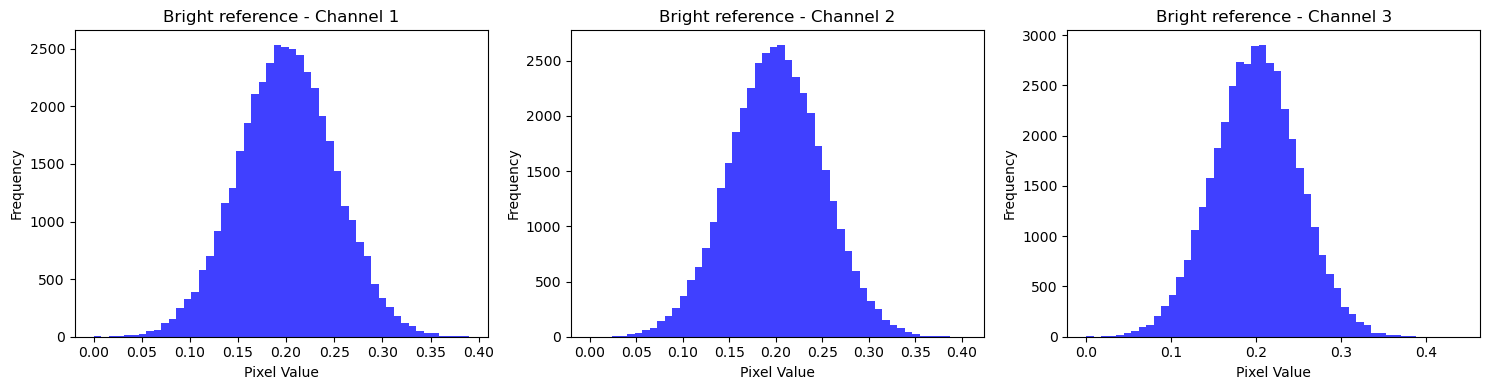

In [3]:
X_test = np.load(data_file)
bright_reference = create_bright_reference()
plot_histograms(bright_reference, "Bright reference")
X_test = histogram_match_images(X_test, bright_reference)

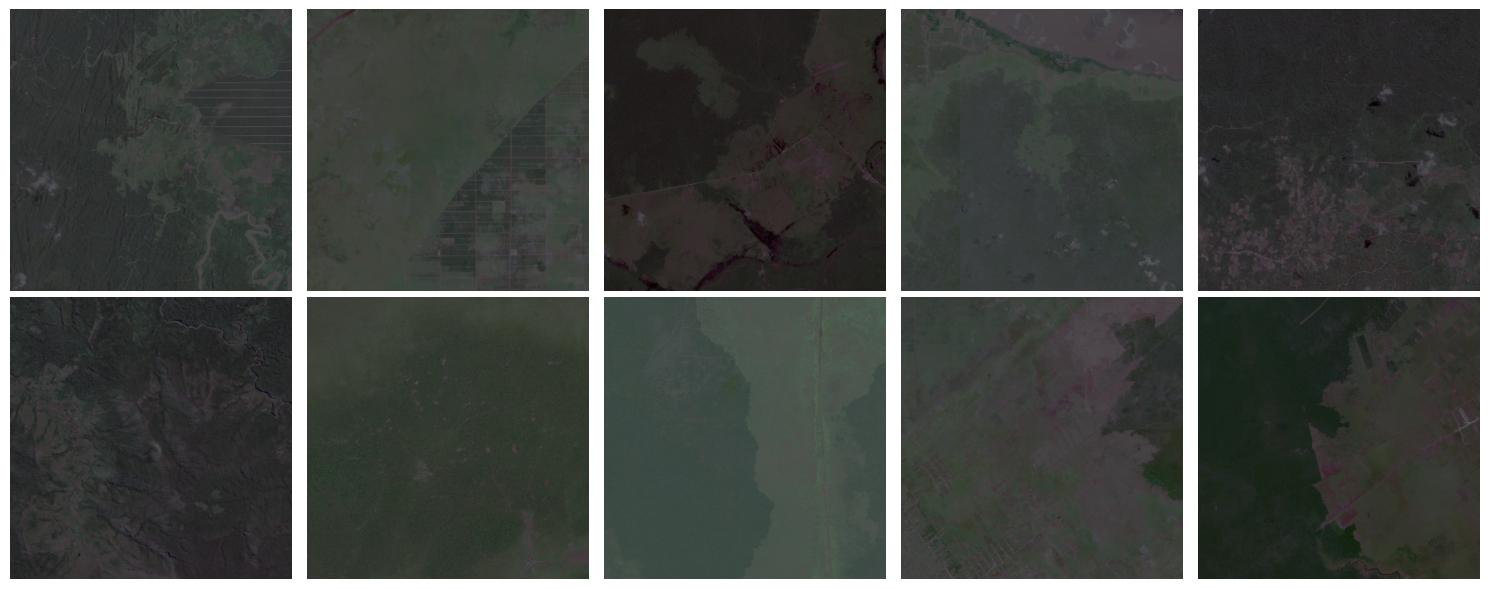

In [ ]:
from original_utils import visualize_images

visualize_images(X_test, 10)

In [ ]:
parent_dir = os.path.split(os.getcwd())[0]
path = os.path.join(parent_dir, "pseudoseg_raw.pkl")

if os.path.exists(path):
    with open(path, "rb") as f:
        pseudoseg_data = pickle.load(f)
    print(f"Successfully loaded pseudosegmentation data from {path}")
    print(f"Type: {type(pseudoseg_data)}")
    print(f"List length: {len(pseudoseg_data)}")
else:
    print(f"File not found: {path}")

Successfully loaded pseudosegmentation data from /Users/martin/Desktop/inf367project/pseudoseg_raw.pkl
Type: <class 'list'>
List length: 118


X_test shape: (118, 3, 1024, 1024)
Number of images (N): 118
Number of channels (C): 3
Height (H): 1024
Width (W): 1024
Data type: float32
Min value: 0.0
Max value: 0.4412187337875366

Number of items in pseudoseg_data: 118
Match between X_test and pseudoseg_data: True


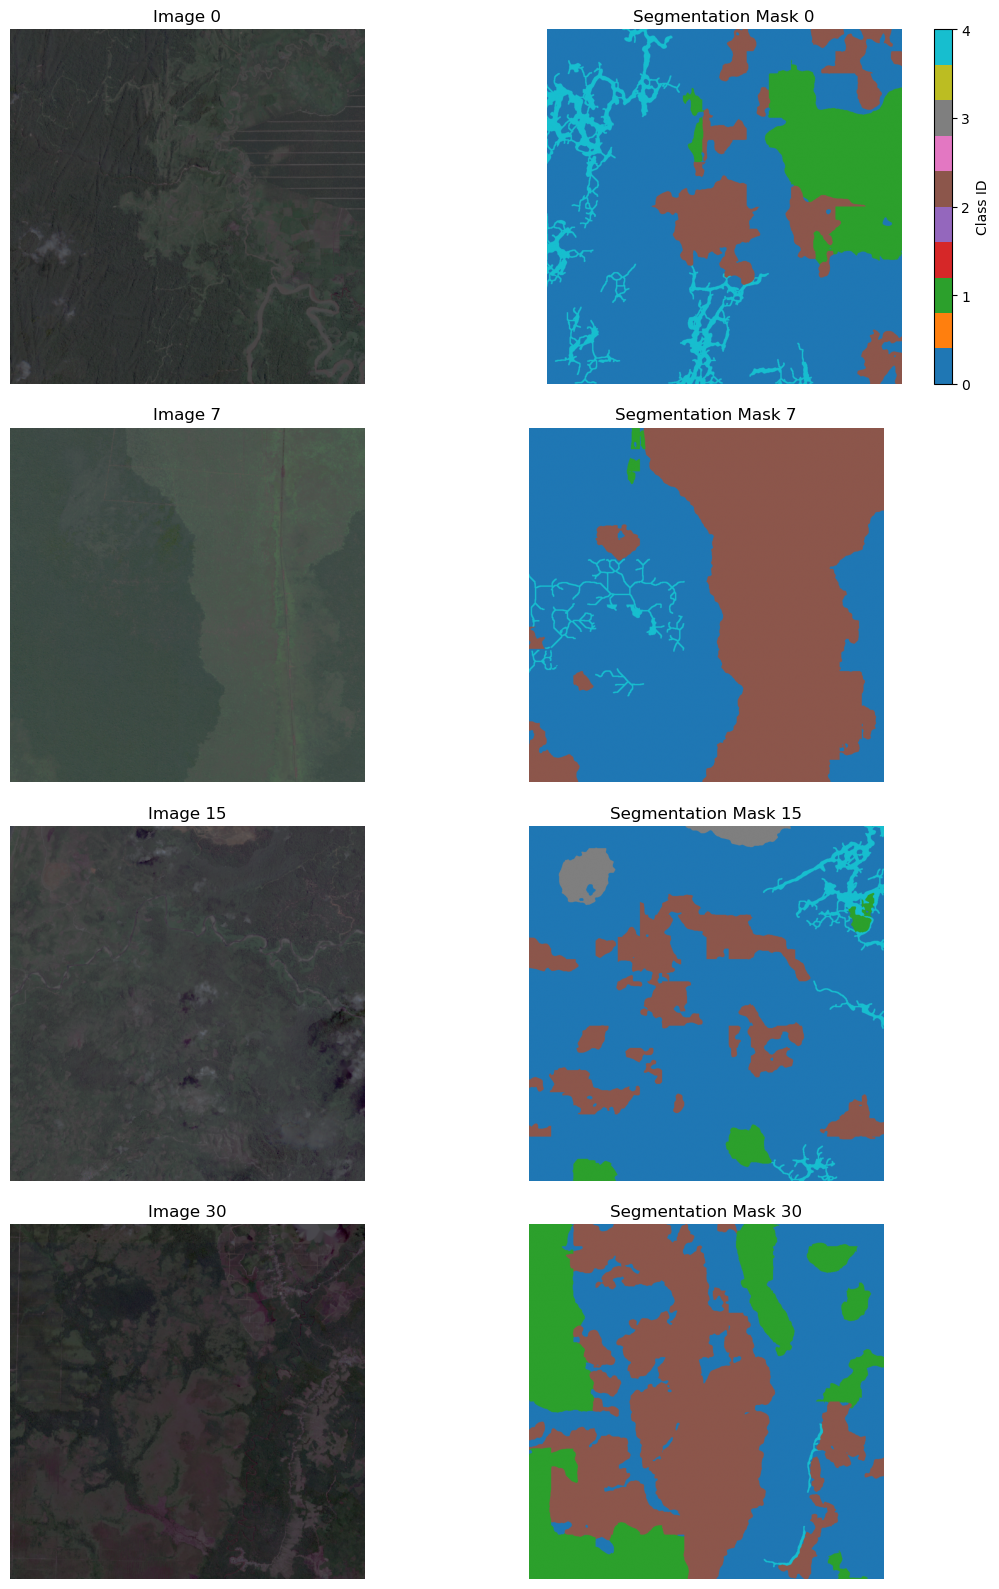

In [ ]:
N, C, H, W = X_test.shape
print(f"X_test shape: {X_test.shape}")
print(f"Number of images (N): {N}")
print(f"Number of channels (C): {C}")
print(f"Height (H): {H}")
print(f"Width (W): {W}")
print(f"Data type: {X_test.dtype}")
print(f"Min value: {X_test.min()}")
print(f"Max value: {X_test.max()}")

print(f"\nNumber of items in pseudoseg_data: {len(pseudoseg_data)}")
print(f"Match between X_test and pseudoseg_data: {N == len(pseudoseg_data)}")

fig, axs = plt.subplots(4, 2, figsize=(12, 16))
sample_indices = [0, 7, 15, 30]  # radnom indices

for i, idx in enumerate(sample_indices):
    img = X_test[idx].transpose(1, 2, 0)
    axs[i, 0].imshow(img)
    axs[i, 0].set_title(f"Image {idx}")
    axs[i, 0].axis("off")

    mask = pseudoseg_data[idx].cpu().numpy()
    axs[i, 1].imshow(mask, cmap="tab10", vmin=0, vmax=4)
    axs[i, 1].set_title(f"Segmentation Mask {idx}")
    axs[i, 1].axis("off")

    if i == 0:
        cbar = fig.colorbar(
            axs[i, 1].imshow(mask, cmap="tab10", vmin=0, vmax=4),
            ax=axs[i, 1],
            ticks=np.arange(5),
        )
        cbar.set_label("Class ID")

plt.tight_layout()
plt.show()

In [ ]:
print(f"Type of pseudoseg_data: {type(pseudoseg_data)}")
print(f"Number of items: {len(pseudoseg_data)}")

first_item = pseudoseg_data[0]
print(f"\nFirst item type: {type(first_item)}")
print(f"First item shape: {first_item.shape}")
print(f"First item dtype: {first_item.dtype}")

unique_values, counts = torch.unique(first_item, return_counts=True)
print(f"\nUnique values in first item: {unique_values.tolist()}")
print(f"Counts of unique values: {counts.tolist()}")

shapes_same = all(item.shape == first_item.shape for item in pseudoseg_data)
print(f"\nAll items have the same shape: {shapes_same}")

all_unique_values = set()
for item in pseudoseg_data[:10]:  # Sample first 10 items
    all_unique_values.update(torch.unique(item).tolist())
print(f"\nUnique values across first 10 items: {sorted(all_unique_values)}")

print(f"\nLength of pseudoseg_data: {len(pseudoseg_data)}")
print(f"Number of images in X_test: {X_test.shape[0]}")

Type of pseudoseg_data: <class 'list'>
Number of items: 118

First item type: <class 'torch.Tensor'>
First item shape: torch.Size([1024, 1024])
First item dtype: torch.int64

Unique values in first item: [0, 1, 2, 4]
Counts of unique values: [706399, 145218, 125467, 71492]

All items have the same shape: True

Unique values across first 10 items: [0, 1, 2, 4]

Length of pseudoseg_data: 118
Number of images in X_test: 118


# Load SAM2 Predictor

In [ ]:
def load_sam_predictor(
    model_cfg: str, checkpoint_path: str, device: str
) -> SAM2ImagePredictor:
    """Loads the SAM2 model and creates a predictor."""
    print("Loading SAM2 model...")
    print(f"  - Config: {model_cfg}")
    print(f"  - Checkpoint: {checkpoint_path}")
    print(f"  - Device: {device}")
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"SAM checkpoint not found: {checkpoint_path}")
    sam2_model = build_sam2(model_cfg, checkpoint_path, device=device)
    predictor = SAM2ImagePredictor(sam2_model)
    print("SAM2 predictor loaded successfully.")
    return predictor


BASE_DIR = parent_dir = os.path.split(os.getcwd())[0]
DATA_FILE = os.path.join(BASE_DIR, "evaluation_images/prepared_test_data_rgb.npy")
SAM_CHECKPOINT = os.path.join(BASE_DIR, "weights/sam2.1_hiera_large.pt")
MODEL_CONFIG = "configs/sam2.1/sam2.1_hiera_l"

device = "cuda" if torch.cuda.is_available() else "cpu"
predictor = load_sam_predictor(MODEL_CONFIG, SAM_CHECKPOINT, device)

Loading SAM2 model...
  - Config: configs/sam2.1/sam2.1_hiera_l
  - Checkpoint: /Users/martin/Desktop/inf367project/weights/sam2.1_hiera_large.pt
  - Device: cpu
SAM2 predictor loaded successfully.


# Helper function and main refinement function

In [ ]:
def _prepare_image_for_sam(image_np: np.ndarray, H: int, W: int) -> np.ndarray:
    """Checks and converts image to HWC uint8 format expected by SAM predictor."""
    C = 3
    prepared_image = image_np.copy()
    if prepared_image.shape == (C, H, W):
        prepared_image = np.transpose(prepared_image, (1, 2, 0))
    elif len(prepared_image.shape) == 2:
        prepared_image = cv2.cvtColor(prepared_image, cv2.COLOR_GRAY2RGB)
    elif prepared_image.shape == (H, W, 1):
        prepared_image = cv2.cvtColor(prepared_image, cv2.COLOR_GRAY2RGB)
    elif prepared_image.shape != (H, W, C):
        raise ValueError(f"Unexpected image shape: {prepared_image.shape}.")
    if prepared_image.dtype != np.uint8:
        if (
            np.issubdtype(prepared_image.dtype, np.floating)
            and prepared_image.max() <= 1.0
            and prepared_image.min() >= 0.0
        ):
            prepared_image = (prepared_image * 255).astype(np.uint8)
        elif np.issubdtype(prepared_image.dtype, np.integer):
            prepared_image = np.clip(prepared_image, 0, 255).astype(np.uint8)
        else:
            raise TypeError(f"Unsupported image dtype: {prepared_image.dtype}.")
    if prepared_image.shape != (H, W, C) or prepared_image.dtype != np.uint8:
        raise RuntimeError("Image prep failed.")
    return prepared_image


def refine_single_segmentation_box_prompt_class_thresh(
    psuedoseg_mask_tensor: torch.Tensor,
    image_np: np.ndarray,
    predictor,
    class_info: dict,
    score_thresholds: dict,
    skip_refine_label: int = 4,
):
    """
    Refines segmentation using SAM2 BOX prompts, SKIPPING refinement for skip_refine_label
    and filtering others by CLASS-SPECIFIC predicted IoU scores.
    """
    H, W = psuedoseg_mask_tensor.shape
    original_mask_np_int64 = psuedoseg_mask_tensor.cpu().numpy().astype(np.int64)

    try:
        prepared_image_np = _prepare_image_for_sam(image_np, H, W)
    except (ValueError, TypeError, RuntimeError) as e:
        print(f"ERROR: Could not prepare input image: {e}")
        return original_mask_np_int64

    psuedoseg_mask_np_uint8 = psuedoseg_mask_tensor.cpu().numpy().astype(np.uint8)
    boxes_to_refine = []
    classes_to_refine = []

    for class_name, (_, _, class_label) in class_info.items():
        if class_label == 0 or class_label == skip_refine_label:
            continue
        binary_mask = (psuedoseg_mask_np_uint8 == class_label).astype(np.uint8)
        num_labels, instance_map, stats, centroids = cv2.connectedComponentsWithStats(
            binary_mask, connectivity=8
        )
        for instance_idx in range(1, num_labels):
            x, y, w, h = (
                stats[instance_idx, cv2.CC_STAT_LEFT],
                stats[instance_idx, cv2.CC_STAT_TOP],
                stats[instance_idx, cv2.CC_STAT_WIDTH],
                stats[instance_idx, cv2.CC_STAT_HEIGHT],
            )
            boxes_to_refine.append([x, y, x + w, y + h])
            classes_to_refine.append(class_label)

    if not boxes_to_refine:
        return original_mask_np_int64

    # run SAM2 Prediction (Using BOX Prompts)
    masks, scores = None, None
    prediction_successful = False
    image_was_set = False
    try:
        predictor.set_image(prepared_image_np)
        image_was_set = True
        input_boxes = np.array(boxes_to_refine)
        masks, scores, _ = predictor.predict(box=input_boxes, multimask_output=False)
        prediction_successful = True
    except Exception as e:
        print(f"ERROR during SAM prediction phase (box prompts): {e}")
        return original_mask_np_int64
    finally:
        if image_was_set:
            try:
                predictor.reset_predictor()
            except Exception as reset_e:
                print(f"Error during predictor.reset_predictor(): {reset_e}")

    # Reconstruct Refined Class Map (Using CLASS-SPECIFIC Score Thresholds)
    if not prediction_successful or masks is None or scores is None:
        print(
            "Warning: Prediction failed or no masks/scores generated. Returning original."
        )
        return original_mask_np_int64

    refined_mask_np = np.zeros((H, W), dtype=np.int64)
    threshold = predictor.mask_threshold

    num_masks_applied = 0
    num_skipped_low_score = 0
    for i in range(masks.shape[0]):
        current_score = scores[i]
        class_label = classes_to_refine[i]
        specific_score_threshold = score_thresholds.get(class_label, 0.0)

        if current_score < specific_score_threshold:
            num_skipped_low_score += 1
            continue

        current_mask_output = masks[i]

        if current_mask_output.shape[0] == 1:
            sam_mask_np = np.squeeze(current_mask_output, axis=0)
        elif len(current_mask_output.shape) == 2:
            sam_mask_np = current_mask_output
        else:
            print(
                f"Warning: Unexpected mask shape {current_mask_output.shape} for mask index {i}. Skipping."
            )
            continue

        sam_mask_bool = None
        if np.issubdtype(sam_mask_np.dtype, np.floating):
            sam_mask_bool = sam_mask_np > threshold
        elif sam_mask_np.dtype == bool:
            sam_mask_bool = sam_mask_np
        else:
            sam_mask_bool = sam_mask_np > 0

        if sam_mask_bool is not None:
            if sam_mask_bool.shape == refined_mask_np.shape:
                refined_mask_np[sam_mask_bool] = class_label
                num_masks_applied += 1
            else:
                print(
                    f"Warning: Shape mismatch AFTER squeeze mask {i} ({sam_mask_bool.shape} vs {refined_mask_np.shape}). Skipping assignment."
                )

    if masks.shape[0] > 0:
        print(
            f"Info: Applied {num_masks_applied} masks out of {masks.shape[0]} predictions after class-specific score filtering ({num_skipped_low_score} skipped)."
        )

    #  Preserve Original Skipped Class (Logging)
    original_skipped_pixels = original_mask_np_int64 == skip_refine_label
    refined_mask_np[original_skipped_pixels] = skip_refine_label

    return refined_mask_np


print("Helper and refinement functions defined.")

Helper and refinement functions defined.


# Execute refinement loop and save results

In [ ]:
annotation_color_allocation = {
    "background": ("black", (0, 0, 0), 0),
    "plantation": ("red", (255, 0, 0), 1),
    "grassland_shrubland": ("green", (0, 255, 0), 2),
    "mining": ("blue", (0, 0, 255), 3),
    "logging": ("yellow", (255, 255, 0), 4),
}
label_to_classname = {v[2]: k for k, v in annotation_color_allocation.items()}

CLASS_SCORE_THRESHOLDS = {
    1: 0.80,  # Plantation
    2: 0.10,  # Grassland/Shrubland
    3: 0.80,  # Mining
}
LABEL_TO_SKIP_REFINEMENT = 4  #'logging'

results_list_name = "refined_segmentations_box_class_thresh"
locals()[results_list_name] = []
failed_indices = []

print(
    f"Starting BOX-PROMPT refinement with CLASS-SPECIFIC thresholds for {len(pseudoseg_data)} images."
)
print(f"Skipping refinement for label: {LABEL_TO_SKIP_REFINEMENT}")
print(f"Using class thresholds: {CLASS_SCORE_THRESHOLDS}")

if (
    "predictor" not in locals()
    or "pseudoseg_data" not in locals()
    or "X_test" not in locals()
    or "annotation_color_allocation" not in locals()
    or "refine_single_segmentation_box_prompt_class_thresh" not in locals()
):
    print(
        "!!! FATAL ERROR !!! Required variables/functions not loaded. Stopping execution."
    )
else:
    for i in tqdm(range(len(pseudoseg_data))):
        print(f"\n--- Starting Processing for Image Index: {i} ---")
        psuedoseg_mask = pseudoseg_data[i]
        image = X_test[i]
        original_mask_np_int64 = psuedoseg_mask.cpu().numpy().astype(np.int64)

        try:
            refined_mask = refine_single_segmentation_box_prompt_class_thresh(
                psuedoseg_mask_tensor=psuedoseg_mask,
                image_np=image,
                predictor=predictor,
                class_info=annotation_color_allocation,
                score_thresholds=CLASS_SCORE_THRESHOLDS,  # Pass the dictionary
                skip_refine_label=LABEL_TO_SKIP_REFINEMENT,
            )
            locals()[results_list_name].append(refined_mask)

        except Exception as e:
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print(f"CRITICAL ERROR processing image index {i}. Storing original mask.")
            print(f"Error details: {e}")
            traceback.print_exc()
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            locals()[results_list_name].append(original_mask_np_int64)
            failed_indices.append(i)

    print("\n========================================================")
    print("Box-Prompt refinement with Class-Specific Thresholds finished.")
    num_processed_attempts = len(locals()[results_list_name])
    num_critical_failures = len(failed_indices)
    print(f"Total images attempted: {len(pseudoseg_data)}")
    print(
        f"Total results generated (incl. originals on failure): {num_processed_attempts}"
    )
    print(f"Indices with critical errors during loop: {failed_indices}")
    print("========================================================")

    if num_processed_attempts > 0:
        try:
            thresh_str = "_".join(
                [
                    f"c{k}t{str(v).replace('.', 'p')}"
                    for k, v in CLASS_SCORE_THRESHOLDS.items()
                ]
            )
            save_filename = f"refined_masks_boxprompt_classthresh_{thresh_str}_skip{LABEL_TO_SKIP_REFINEMENT}.npz"
            current_dir = os.getcwd()
            parent_dir = os.path.dirname(current_dir)
            save_path = os.path.join(parent_dir, save_filename)
            if not os.access(parent_dir, os.W_OK):
                print(
                    f"Warning: Parent directory '{parent_dir}' not writable. Saving to current directory."
                )
                save_path = os.path.join(current_dir, save_filename)

            np.savez_compressed(
                save_path,
                **{
                    f"mask_{i}": mask
                    for i, mask in enumerate(locals()[results_list_name])
                },
            )
            print(f"Refined segmentations saved to: {save_path}")
        except Exception as e:
            print(f"Error saving data: {e}")
    else:
        print("No results generated, skipping save.")

Starting BOX-PROMPT refinement with CLASS-SPECIFIC thresholds for 118 images.
Skipping refinement for label: 4
Using class thresholds: {1: 0.8, 2: 0.1, 3: 0.8}


  0%|          | 0/118 [00:00<?, ?it/s]


--- Starting Processing for Image Index: 0 ---


  1%|          | 1/118 [00:03<06:34,  3.37s/it]

Info: Applied 12 masks out of 14 predictions after class-specific score filtering (2 skipped).

--- Starting Processing for Image Index: 1 ---


  2%|▏         | 2/118 [00:07<06:51,  3.55s/it]

Info: Applied 5 masks out of 6 predictions after class-specific score filtering (1 skipped).

--- Starting Processing for Image Index: 2 ---


  3%|▎         | 3/118 [00:09<06:14,  3.25s/it]

Info: Applied 6 masks out of 8 predictions after class-specific score filtering (2 skipped).

--- Starting Processing for Image Index: 3 ---


  3%|▎         | 4/118 [00:12<05:48,  3.06s/it]

Info: Applied 3 masks out of 3 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 4 ---


  4%|▍         | 5/118 [00:15<05:29,  2.92s/it]

Info: Applied 3 masks out of 4 predictions after class-specific score filtering (1 skipped).

--- Starting Processing for Image Index: 5 ---


  5%|▌         | 6/118 [00:18<05:32,  2.97s/it]

Info: Applied 21 masks out of 21 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 6 ---


  6%|▌         | 7/118 [00:21<05:19,  2.88s/it]

Info: Applied 5 masks out of 5 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 7 ---


  7%|▋         | 8/118 [00:24<05:16,  2.88s/it]

Info: Applied 6 masks out of 7 predictions after class-specific score filtering (1 skipped).

--- Starting Processing for Image Index: 8 ---


  8%|▊         | 9/118 [00:26<05:11,  2.86s/it]

Info: Applied 3 masks out of 3 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 9 ---


  8%|▊         | 10/118 [00:29<05:04,  2.82s/it]

Info: Applied 7 masks out of 7 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 10 ---


  9%|▉         | 11/118 [00:32<05:07,  2.87s/it]

Info: Applied 8 masks out of 10 predictions after class-specific score filtering (2 skipped).

--- Starting Processing for Image Index: 11 ---


 10%|█         | 12/118 [00:35<05:20,  3.02s/it]

Info: Applied 19 masks out of 21 predictions after class-specific score filtering (2 skipped).

--- Starting Processing for Image Index: 12 ---


 11%|█         | 13/118 [00:38<05:15,  3.01s/it]

Info: Applied 15 masks out of 19 predictions after class-specific score filtering (4 skipped).

--- Starting Processing for Image Index: 13 ---


 12%|█▏        | 14/118 [00:42<05:22,  3.10s/it]

Info: Applied 19 masks out of 22 predictions after class-specific score filtering (3 skipped).

--- Starting Processing for Image Index: 14 ---


 13%|█▎        | 15/118 [00:45<05:28,  3.19s/it]

Info: Applied 12 masks out of 14 predictions after class-specific score filtering (2 skipped).

--- Starting Processing for Image Index: 15 ---


 14%|█▎        | 16/118 [00:48<05:26,  3.20s/it]

Info: Applied 19 masks out of 20 predictions after class-specific score filtering (1 skipped).

--- Starting Processing for Image Index: 16 ---


 14%|█▍        | 17/118 [00:51<05:06,  3.03s/it]

Info: Applied 2 masks out of 2 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 17 ---


 15%|█▌        | 18/118 [00:54<04:53,  2.93s/it]

Info: Applied 6 masks out of 10 predictions after class-specific score filtering (4 skipped).

--- Starting Processing for Image Index: 18 ---


 16%|█▌        | 19/118 [00:56<04:44,  2.87s/it]

Info: Applied 5 masks out of 6 predictions after class-specific score filtering (1 skipped).

--- Starting Processing for Image Index: 19 ---


 17%|█▋        | 20/118 [00:59<04:45,  2.92s/it]

Info: Applied 7 masks out of 7 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 20 ---


 18%|█▊        | 21/118 [01:02<04:44,  2.93s/it]

Info: Applied 12 masks out of 15 predictions after class-specific score filtering (3 skipped).

--- Starting Processing for Image Index: 21 ---


 19%|█▊        | 22/118 [01:05<04:41,  2.93s/it]

Info: Applied 12 masks out of 13 predictions after class-specific score filtering (1 skipped).

--- Starting Processing for Image Index: 22 ---


 19%|█▉        | 23/118 [01:08<04:29,  2.83s/it]

Info: Applied 6 masks out of 6 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 23 ---


 20%|██        | 24/118 [01:11<04:31,  2.89s/it]

Info: Applied 15 masks out of 20 predictions after class-specific score filtering (5 skipped).

--- Starting Processing for Image Index: 24 ---


 21%|██        | 25/118 [01:14<04:22,  2.83s/it]

Info: Applied 9 masks out of 9 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 25 ---


 22%|██▏       | 26/118 [01:17<04:24,  2.88s/it]

Info: Applied 10 masks out of 11 predictions after class-specific score filtering (1 skipped).

--- Starting Processing for Image Index: 26 ---


 23%|██▎       | 27/118 [01:19<04:20,  2.87s/it]

Info: Applied 6 masks out of 6 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 27 ---


 24%|██▎       | 28/118 [01:22<04:16,  2.85s/it]

Info: Applied 6 masks out of 8 predictions after class-specific score filtering (2 skipped).

--- Starting Processing for Image Index: 28 ---


 25%|██▍       | 29/118 [01:25<04:17,  2.89s/it]

Info: Applied 12 masks out of 13 predictions after class-specific score filtering (1 skipped).

--- Starting Processing for Image Index: 29 ---


 25%|██▌       | 30/118 [01:28<04:07,  2.81s/it]

Info: Applied 1 masks out of 1 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 30 ---


 26%|██▋       | 31/118 [01:31<04:07,  2.85s/it]

Info: Applied 15 masks out of 17 predictions after class-specific score filtering (2 skipped).

--- Starting Processing for Image Index: 31 ---


 27%|██▋       | 32/118 [01:34<04:06,  2.87s/it]

Info: Applied 9 masks out of 9 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 32 ---


 28%|██▊       | 33/118 [01:37<04:05,  2.89s/it]

Info: Applied 15 masks out of 15 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 33 ---


 29%|██▉       | 34/118 [01:40<04:23,  3.14s/it]

Info: Applied 9 masks out of 22 predictions after class-specific score filtering (13 skipped).

--- Starting Processing for Image Index: 34 ---


 30%|██▉       | 35/118 [01:43<04:13,  3.05s/it]

Info: Applied 17 masks out of 17 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 35 ---


 31%|███       | 36/118 [01:46<04:00,  2.94s/it]

Info: Applied 4 masks out of 4 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 36 ---


 31%|███▏      | 37/118 [01:48<03:46,  2.80s/it]

Info: Applied 3 masks out of 3 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 37 ---


 32%|███▏      | 38/118 [01:52<04:01,  3.02s/it]

Info: Applied 11 masks out of 12 predictions after class-specific score filtering (1 skipped).

--- Starting Processing for Image Index: 38 ---


 33%|███▎      | 39/118 [01:55<03:52,  2.95s/it]

Info: Applied 4 masks out of 4 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 39 ---


 34%|███▍      | 40/118 [01:58<03:52,  2.98s/it]

Info: Applied 18 masks out of 24 predictions after class-specific score filtering (6 skipped).

--- Starting Processing for Image Index: 40 ---


 35%|███▍      | 41/118 [02:01<03:48,  2.96s/it]

Info: Applied 11 masks out of 14 predictions after class-specific score filtering (3 skipped).

--- Starting Processing for Image Index: 41 ---


 36%|███▌      | 42/118 [02:04<03:43,  2.94s/it]

Info: Applied 12 masks out of 14 predictions after class-specific score filtering (2 skipped).

--- Starting Processing for Image Index: 42 ---


 36%|███▋      | 43/118 [02:06<03:39,  2.93s/it]

Info: Applied 18 masks out of 18 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 43 ---


 37%|███▋      | 44/118 [02:09<03:37,  2.94s/it]

Info: Applied 9 masks out of 11 predictions after class-specific score filtering (2 skipped).

--- Starting Processing for Image Index: 44 ---


 38%|███▊      | 45/118 [02:12<03:32,  2.92s/it]

Info: Applied 13 masks out of 13 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 45 ---


 39%|███▉      | 46/118 [02:15<03:26,  2.86s/it]

Info: Applied 9 masks out of 11 predictions after class-specific score filtering (2 skipped).

--- Starting Processing for Image Index: 46 ---


 40%|███▉      | 47/118 [02:18<03:23,  2.86s/it]

Info: Applied 6 masks out of 7 predictions after class-specific score filtering (1 skipped).

--- Starting Processing for Image Index: 47 ---


 41%|████      | 48/118 [02:20<03:14,  2.78s/it]

Info: Applied 8 masks out of 9 predictions after class-specific score filtering (1 skipped).

--- Starting Processing for Image Index: 48 ---


 42%|████▏     | 49/118 [02:23<03:12,  2.79s/it]

Info: Applied 4 masks out of 4 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 49 ---


 42%|████▏     | 50/118 [02:26<03:12,  2.84s/it]

Info: Applied 9 masks out of 10 predictions after class-specific score filtering (1 skipped).

--- Starting Processing for Image Index: 50 ---


 43%|████▎     | 51/118 [02:29<03:03,  2.74s/it]

Info: Applied 8 masks out of 8 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 51 ---


 44%|████▍     | 52/118 [02:32<03:04,  2.80s/it]

Info: Applied 11 masks out of 11 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 52 ---


 45%|████▍     | 53/118 [02:34<03:00,  2.78s/it]

Info: Applied 10 masks out of 16 predictions after class-specific score filtering (6 skipped).

--- Starting Processing for Image Index: 53 ---


 46%|████▌     | 54/118 [02:37<02:51,  2.69s/it]

Info: Applied 4 masks out of 6 predictions after class-specific score filtering (2 skipped).

--- Starting Processing for Image Index: 54 ---


 47%|████▋     | 55/118 [02:40<02:55,  2.79s/it]

Info: Applied 25 masks out of 29 predictions after class-specific score filtering (4 skipped).

--- Starting Processing for Image Index: 55 ---


 47%|████▋     | 56/118 [02:43<02:53,  2.80s/it]

Info: Applied 13 masks out of 14 predictions after class-specific score filtering (1 skipped).

--- Starting Processing for Image Index: 56 ---


 48%|████▊     | 57/118 [02:46<02:52,  2.83s/it]

Info: Applied 11 masks out of 15 predictions after class-specific score filtering (4 skipped).

--- Starting Processing for Image Index: 57 ---


 49%|████▉     | 58/118 [02:48<02:50,  2.84s/it]

Info: Applied 16 masks out of 23 predictions after class-specific score filtering (7 skipped).

--- Starting Processing for Image Index: 58 ---


 50%|█████     | 59/118 [02:51<02:40,  2.72s/it]

Info: Applied 6 masks out of 11 predictions after class-specific score filtering (5 skipped).

--- Starting Processing for Image Index: 59 ---


 51%|█████     | 60/118 [02:54<02:35,  2.67s/it]

Info: Applied 8 masks out of 8 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 60 ---


 52%|█████▏    | 61/118 [02:56<02:33,  2.70s/it]

Info: Applied 12 masks out of 15 predictions after class-specific score filtering (3 skipped).

--- Starting Processing for Image Index: 61 ---


 53%|█████▎    | 62/118 [02:59<02:28,  2.65s/it]

Info: Applied 3 masks out of 3 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 62 ---


 53%|█████▎    | 63/118 [03:01<02:25,  2.65s/it]

Info: Applied 14 masks out of 15 predictions after class-specific score filtering (1 skipped).

--- Starting Processing for Image Index: 63 ---


 54%|█████▍    | 64/118 [03:04<02:21,  2.63s/it]

Info: Applied 12 masks out of 13 predictions after class-specific score filtering (1 skipped).

--- Starting Processing for Image Index: 64 ---


 55%|█████▌    | 65/118 [03:06<02:15,  2.56s/it]

Info: Applied 7 masks out of 7 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 65 ---


 56%|█████▌    | 66/118 [03:09<02:10,  2.51s/it]

Info: Applied 7 masks out of 8 predictions after class-specific score filtering (1 skipped).

--- Starting Processing for Image Index: 66 ---


 57%|█████▋    | 67/118 [03:12<02:13,  2.61s/it]

Info: Applied 9 masks out of 9 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 67 ---


 58%|█████▊    | 68/118 [03:15<02:19,  2.79s/it]

Info: Applied 16 masks out of 20 predictions after class-specific score filtering (4 skipped).

--- Starting Processing for Image Index: 68 ---


 58%|█████▊    | 69/118 [03:17<02:12,  2.70s/it]

Info: Applied 4 masks out of 7 predictions after class-specific score filtering (3 skipped).

--- Starting Processing for Image Index: 69 ---


 59%|█████▉    | 70/118 [03:20<02:05,  2.60s/it]

Info: Applied 4 masks out of 4 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 70 ---


 60%|██████    | 71/118 [03:22<02:01,  2.59s/it]

Info: Applied 10 masks out of 11 predictions after class-specific score filtering (1 skipped).

--- Starting Processing for Image Index: 71 ---


 61%|██████    | 72/118 [03:25<02:00,  2.62s/it]

Info: Applied 3 masks out of 3 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 72 ---


 62%|██████▏   | 73/118 [03:28<02:01,  2.71s/it]

Info: Applied 21 masks out of 23 predictions after class-specific score filtering (2 skipped).

--- Starting Processing for Image Index: 73 ---


 63%|██████▎   | 74/118 [03:31<01:58,  2.70s/it]

Info: Applied 2 masks out of 2 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 74 ---


 64%|██████▎   | 75/118 [03:33<01:54,  2.66s/it]

Info: Applied 5 masks out of 5 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 75 ---


 64%|██████▍   | 76/118 [03:36<01:49,  2.61s/it]

Info: Applied 6 masks out of 8 predictions after class-specific score filtering (2 skipped).

--- Starting Processing for Image Index: 76 ---


 65%|██████▌   | 77/118 [03:38<01:48,  2.64s/it]

Info: Applied 4 masks out of 4 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 77 ---


 66%|██████▌   | 78/118 [03:41<01:50,  2.77s/it]

Info: Applied 14 masks out of 16 predictions after class-specific score filtering (2 skipped).

--- Starting Processing for Image Index: 78 ---


 67%|██████▋   | 79/118 [03:45<01:52,  2.88s/it]

Info: Applied 2 masks out of 2 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 79 ---


 68%|██████▊   | 80/118 [03:47<01:45,  2.78s/it]

Info: Applied 7 masks out of 8 predictions after class-specific score filtering (1 skipped).

--- Starting Processing for Image Index: 80 ---


 69%|██████▊   | 81/118 [03:50<01:39,  2.68s/it]

Info: Applied 1 masks out of 1 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 81 ---


 69%|██████▉   | 82/118 [03:52<01:32,  2.58s/it]

Info: Applied 2 masks out of 3 predictions after class-specific score filtering (1 skipped).

--- Starting Processing for Image Index: 82 ---


 70%|███████   | 83/118 [03:55<01:31,  2.62s/it]

Info: Applied 17 masks out of 17 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 83 ---


 71%|███████   | 84/118 [03:59<01:42,  3.00s/it]

Info: Applied 12 masks out of 14 predictions after class-specific score filtering (2 skipped).

--- Starting Processing for Image Index: 84 ---


 72%|███████▏  | 85/118 [04:02<01:40,  3.06s/it]

Info: Applied 14 masks out of 18 predictions after class-specific score filtering (4 skipped).

--- Starting Processing for Image Index: 85 ---


 73%|███████▎  | 86/118 [04:05<01:41,  3.17s/it]

Info: Applied 15 masks out of 16 predictions after class-specific score filtering (1 skipped).

--- Starting Processing for Image Index: 86 ---


 74%|███████▎  | 87/118 [04:08<01:33,  3.01s/it]

Info: Applied 7 masks out of 7 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 87 ---


 75%|███████▍  | 88/118 [04:10<01:25,  2.84s/it]

Info: Applied 2 masks out of 2 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 88 ---


 75%|███████▌  | 89/118 [04:13<01:19,  2.74s/it]

Info: Applied 5 masks out of 5 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 89 ---


 76%|███████▋  | 90/118 [04:15<01:16,  2.72s/it]

Info: Applied 7 masks out of 7 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 90 ---


 77%|███████▋  | 91/118 [04:18<01:12,  2.69s/it]

Info: Applied 3 masks out of 3 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 91 ---


 78%|███████▊  | 92/118 [04:21<01:08,  2.65s/it]

Info: Applied 3 masks out of 3 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 92 ---


 79%|███████▉  | 93/118 [04:23<01:06,  2.64s/it]

Info: Applied 7 masks out of 7 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 93 ---


 80%|███████▉  | 94/118 [04:26<01:06,  2.78s/it]

Info: Applied 22 masks out of 27 predictions after class-specific score filtering (5 skipped).

--- Starting Processing for Image Index: 94 ---


 81%|████████  | 95/118 [04:29<01:05,  2.86s/it]

Info: Applied 18 masks out of 21 predictions after class-specific score filtering (3 skipped).

--- Starting Processing for Image Index: 95 ---


 81%|████████▏ | 96/118 [04:32<01:03,  2.90s/it]

Info: Applied 2 masks out of 2 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 96 ---


 82%|████████▏ | 97/118 [04:35<00:59,  2.85s/it]

Info: Applied 2 masks out of 3 predictions after class-specific score filtering (1 skipped).

--- Starting Processing for Image Index: 97 ---


 83%|████████▎ | 98/118 [04:38<00:56,  2.80s/it]

Info: Applied 1 masks out of 1 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 98 ---


 84%|████████▍ | 99/118 [04:41<00:55,  2.92s/it]

Info: Applied 11 masks out of 14 predictions after class-specific score filtering (3 skipped).

--- Starting Processing for Image Index: 99 ---


 85%|████████▍ | 100/118 [04:44<00:51,  2.84s/it]

Info: Applied 1 masks out of 1 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 100 ---


 86%|████████▌ | 101/118 [04:46<00:48,  2.85s/it]

Info: Applied 13 masks out of 15 predictions after class-specific score filtering (2 skipped).

--- Starting Processing for Image Index: 101 ---


 86%|████████▋ | 102/118 [04:49<00:44,  2.77s/it]

Info: Applied 2 masks out of 3 predictions after class-specific score filtering (1 skipped).

--- Starting Processing for Image Index: 102 ---


 87%|████████▋ | 103/118 [04:52<00:42,  2.81s/it]

Info: Applied 10 masks out of 10 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 103 ---


 88%|████████▊ | 104/118 [04:55<00:40,  2.88s/it]

Info: Applied 11 masks out of 15 predictions after class-specific score filtering (4 skipped).

--- Starting Processing for Image Index: 104 ---


 89%|████████▉ | 105/118 [04:59<00:41,  3.22s/it]

Info: Applied 7 masks out of 8 predictions after class-specific score filtering (1 skipped).

--- Starting Processing for Image Index: 105 ---


 90%|████████▉ | 106/118 [05:02<00:36,  3.03s/it]

Info: Applied 6 masks out of 6 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 106 ---


 91%|█████████ | 107/118 [05:04<00:31,  2.87s/it]

Info: Applied 3 masks out of 3 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 107 ---


 92%|█████████▏| 108/118 [05:07<00:28,  2.84s/it]

Info: Applied 9 masks out of 10 predictions after class-specific score filtering (1 skipped).

--- Starting Processing for Image Index: 108 ---


 92%|█████████▏| 109/118 [05:09<00:24,  2.71s/it]

Info: Applied 2 masks out of 2 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 109 ---


 93%|█████████▎| 110/118 [05:12<00:20,  2.62s/it]

Info: Applied 9 masks out of 9 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 110 ---

--- Starting Processing for Image Index: 111 ---


 95%|█████████▍| 112/118 [05:15<00:12,  2.10s/it]

Info: Applied 15 masks out of 17 predictions after class-specific score filtering (2 skipped).

--- Starting Processing for Image Index: 112 ---


 96%|█████████▌| 113/118 [05:17<00:11,  2.27s/it]

Info: Applied 1 masks out of 1 predictions after class-specific score filtering (0 skipped).

--- Starting Processing for Image Index: 113 ---

--- Starting Processing for Image Index: 114 ---


 97%|█████████▋| 115/118 [05:20<00:05,  1.89s/it]

Info: Applied 14 masks out of 15 predictions after class-specific score filtering (1 skipped).

--- Starting Processing for Image Index: 115 ---


 98%|█████████▊| 116/118 [05:23<00:04,  2.06s/it]

Info: Applied 8 masks out of 15 predictions after class-specific score filtering (7 skipped).

--- Starting Processing for Image Index: 116 ---


 99%|█████████▉| 117/118 [05:26<00:02,  2.24s/it]

Info: Applied 5 masks out of 8 predictions after class-specific score filtering (3 skipped).

--- Starting Processing for Image Index: 117 ---


100%|██████████| 118/118 [05:28<00:00,  2.79s/it]

Info: Applied 2 masks out of 3 predictions after class-specific score filtering (1 skipped).

Box-Prompt refinement with Class-Specific Thresholds finished.
Total images attempted: 118
Total results generated (incl. originals on failure): 118
Indices with critical errors during loop: []


Refined segmentations saved to: /Users/martin/Desktop/inf367project/refined_masks_boxprompt_classthresh_c1t0p8_c2t0p1_c3t0p8_skip4.npz


# Visualization

In [ ]:
try:
    colors_rgb = {
        label: tuple(c / 255.0 for c in rgb)
        for name, (cname, rgb, label) in annotation_color_allocation.items()
    }
    class_names = {
        label: name for name, (cname, rgb, label) in annotation_color_allocation.items()
    }
    cmap_list = [
        colors_rgb.get(i, (0, 0, 0)) for i in range(max(colors_rgb.keys()) + 1)
    ]  # Black for missing labels
    custom_cmap = mcolors.ListedColormap(cmap_list)
    norm = mcolors.BoundaryNorm(np.arange(len(cmap_list) + 1) - 0.5, len(cmap_list))
    visualization_ready = True
    print("Colormap and class names prepared for visualization.")
except NameError:
    print("Error: annotation_color_allocation not found. Cannot setup visualization.")
    visualization_ready = False


def visualize_comparison(
    index,
    X_test_data,
    pseudoseg_original_data,
    refined_segmentations_data,
    cmap,
    norm,
    class_names_map,
):
    """Visualizes original image, original mask, and refined mask."""
    if not visualization_ready:
        print("Visualization setup failed, cannot run.")
        return
    if (
        index >= len(X_test_data)
        or index >= len(pseudoseg_original_data)
        or index >= len(refined_segmentations_data)
    ):
        print(f"Index {index} out of bounds.")
        return

    original_image = X_test_data[index]
    original_mask = pseudoseg_original_data[index].cpu().numpy()
    refined_mask = refined_segmentations_data[index]

    # ensure HWC, uint8
    display_image = original_image.copy()
    if (
        len(display_image.shape) == 3
        and display_image.shape[0] == 3
        and display_image.shape[1] != 3
    ):
        display_image = np.transpose(display_image, (1, 2, 0))
    if display_image.dtype != np.uint8:
        if display_image.max() <= 1.0 and np.issubdtype(
            display_image.dtype, np.floating
        ):
            display_image = (display_image * 255).astype(np.uint8)
        else:
            display_image = np.clip(display_image, 0, 255).astype(np.uint8)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Comparison for Image Index: {index}", fontsize=16)

    axes[0].imshow(display_image)
    axes[0].set_title("Original Satellite Image")
    axes[0].axis("off")
    axes[1].imshow(original_mask, cmap=cmap, norm=norm)
    axes[1].set_title("Original Psuedo Mask")
    axes[1].axis("off")
    axes[2].imshow(refined_mask, cmap=cmap, norm=norm)
    axes[2].set_title("Refined SAM Mask")
    axes[2].axis("off")

    patches = [
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=cmap_list[label],
            label=f"{label}: {class_names_map.get(label, 'Unknown')}",
        )
        for label in sorted(colors_rgb.keys())
    ]
    fig.legend(
        handles=patches, bbox_to_anchor=(0.98, 0.5), loc="center left", title="Classes"
    )
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.show()


Colormap and class names prepared for visualization.


# Post-processing analysis & Visualization execution


--- Post-processing / Analysis ---

--- Unique Values & Counts (Sample Images) ---

--- Analysis for Index 0 ---
Label Counts (Original / Refined):
  0 (background...):    706,399 /    708,366
  1 (plantation...):    145,218 /     84,962
  2 (grassland_...):    125,467 /    183,756
  4 (logging...):     71,492 /     71,492

--- Analysis for Index 10 ---
Label Counts (Original / Refined):
  0 (background...):    535,170 /    204,489
  1 (plantation...):     28,264 /     11,685
  2 (grassland_...):    478,938 /    826,198
  4 (logging...):      6,204 /      6,204

--- Analysis for Index 18 ---
Label Counts (Original / Refined):
  0 (background...):    399,832 /    140,916
  1 (plantation...):     38,753 /      1,450
  2 (grassland_...):    609,991 /    906,210

--- Analysis for Index 19 ---
Label Counts (Original / Refined):
  0 (background...):    807,040 /    482,713
  2 (grassland_...):    222,061 /    546,388
  4 (logging...):     19,475 /     19,475

--- Analysis for Index 111 ---


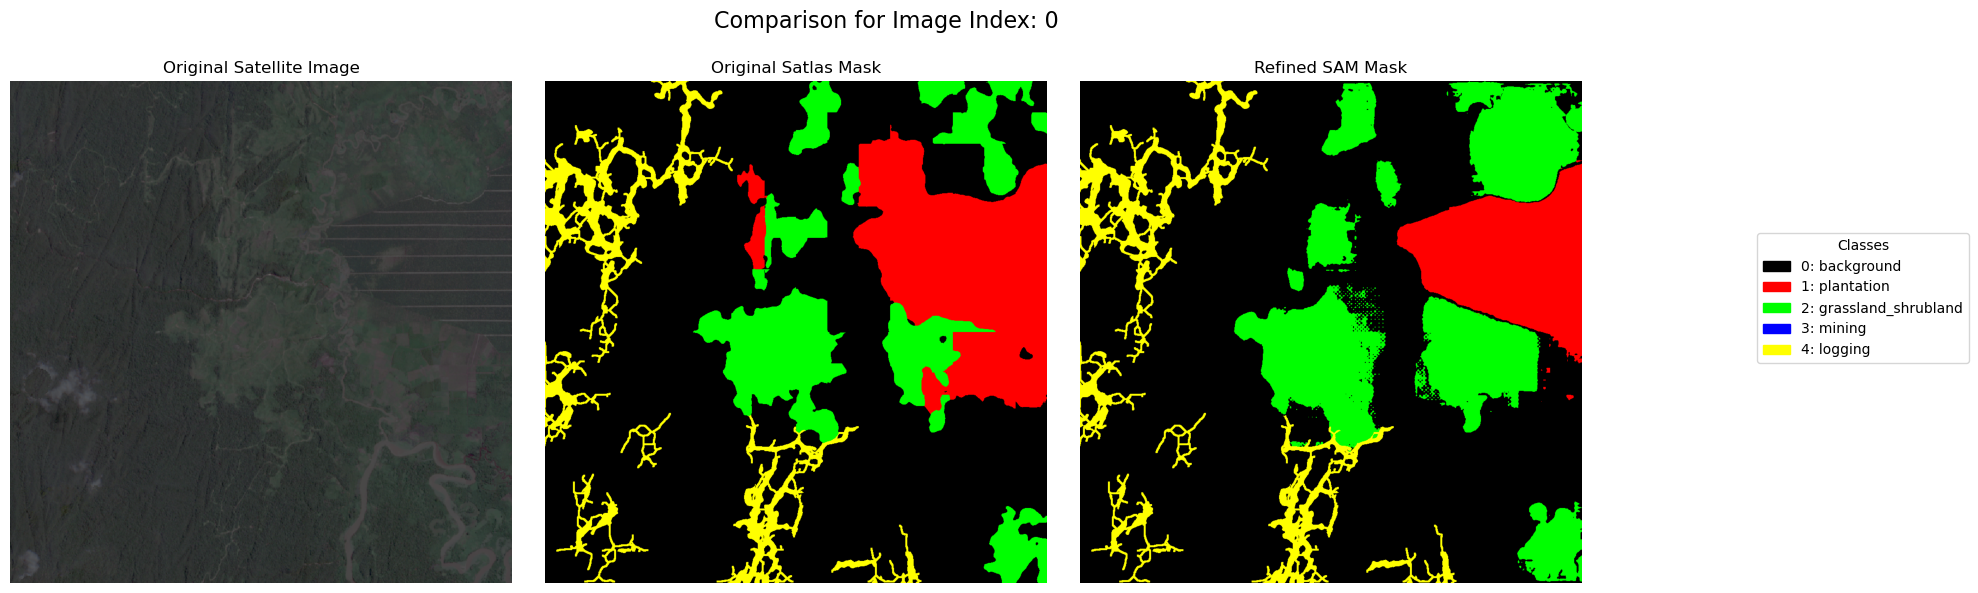

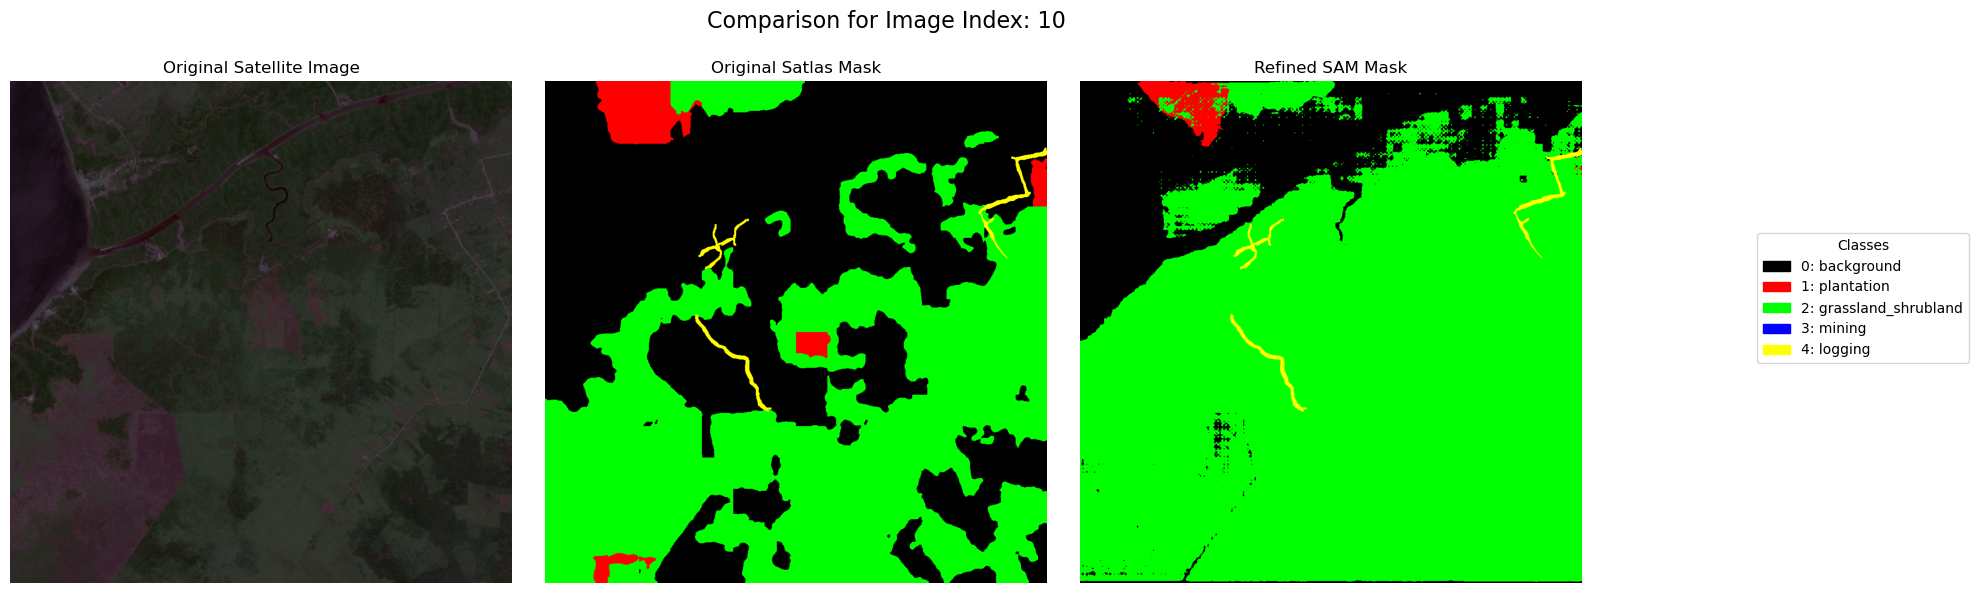

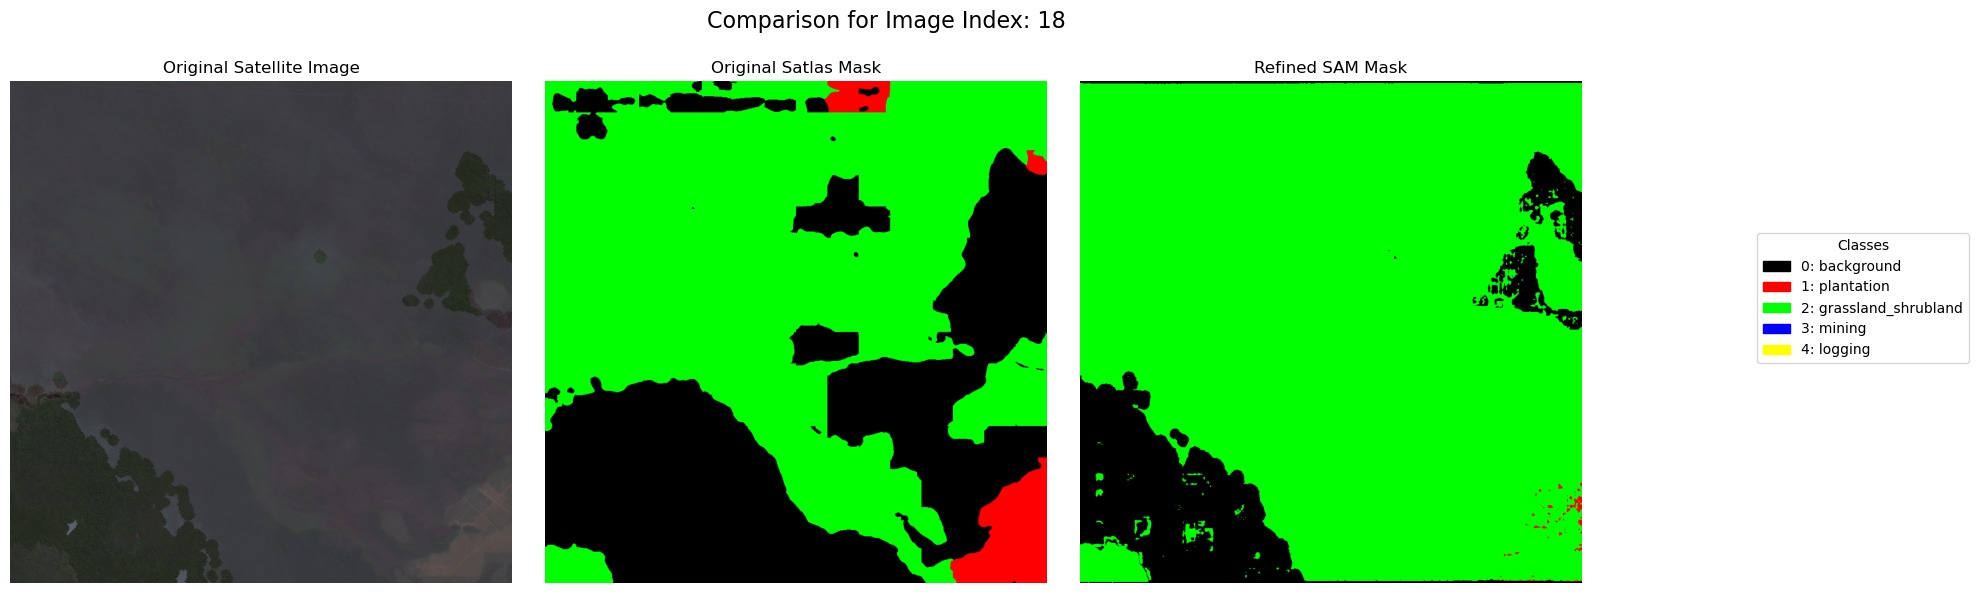

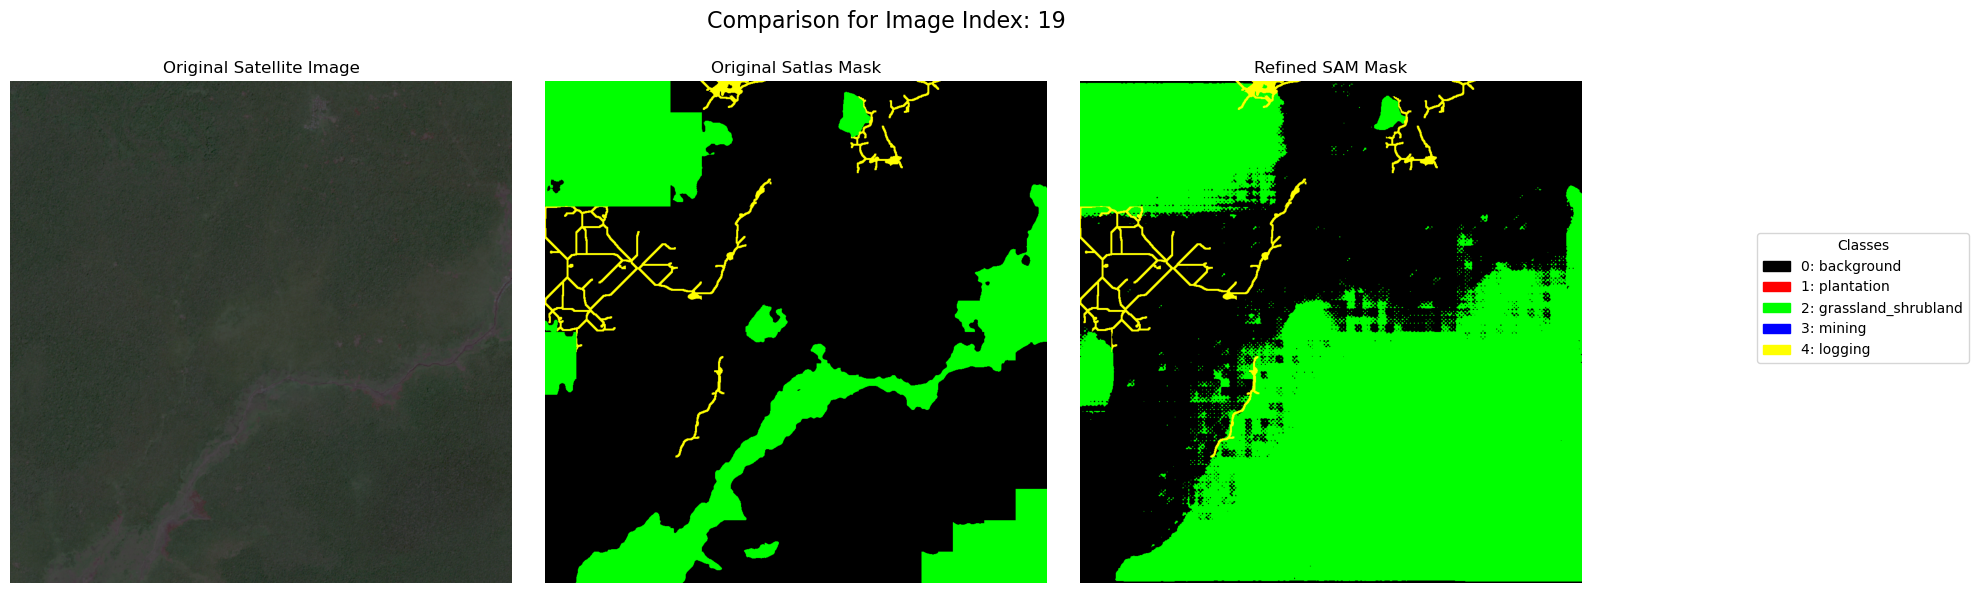

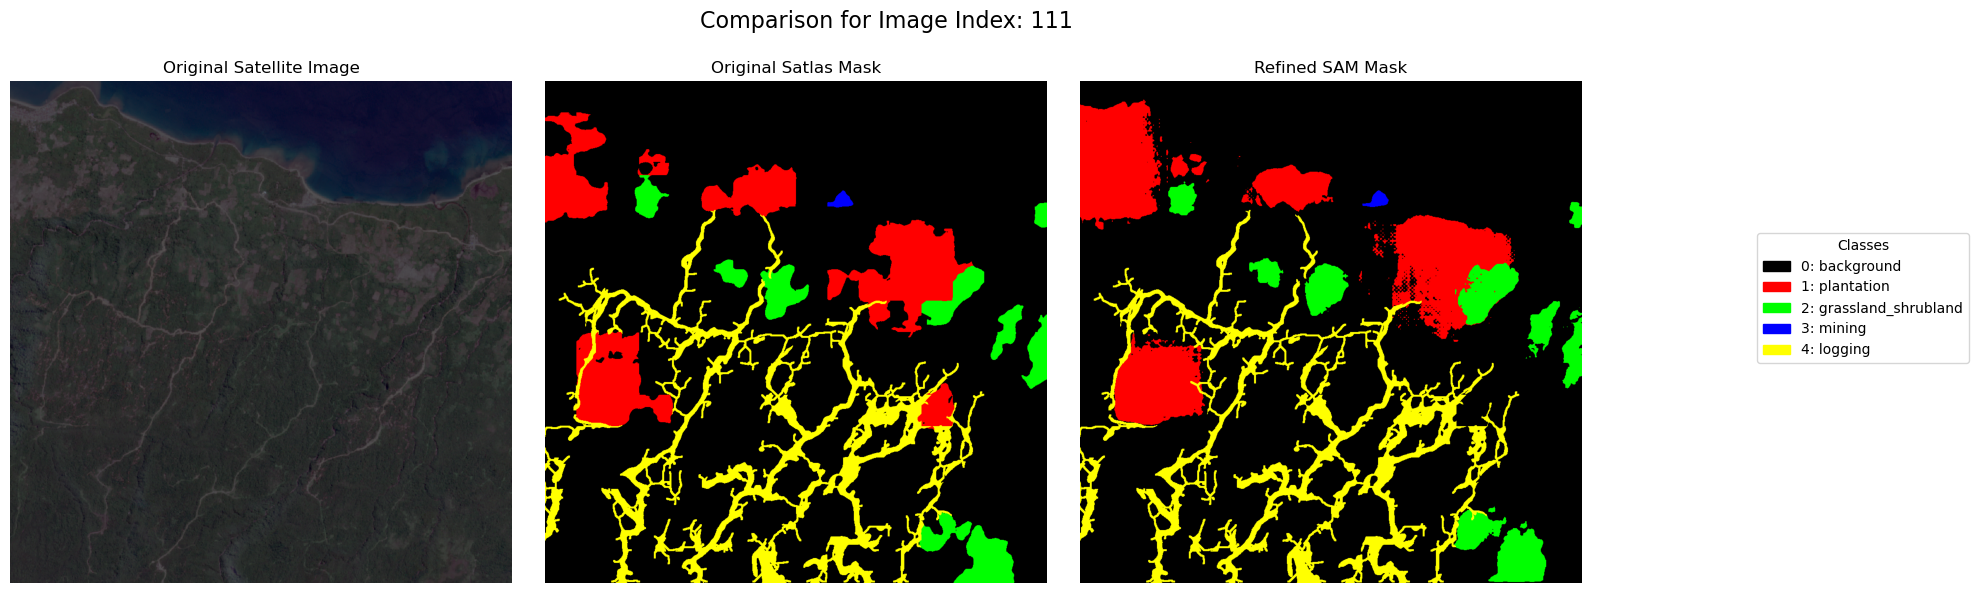


--- Area Change Analysis (Total Pixels Across All Images) ---
Total Pixel Counts per Class (Original vs Refined):
-----------------------------------------------------------------
Class Name                Label     Original Pixels     Refined Pixels   Change (%)
-----------------------------------------------------------------
background                0              60,863,004         49,176,365      -19.20%
plantation                1              37,340,155         40,332,955        8.01%
grassland_shrubland       2              17,007,545         24,562,658       44.42%
mining                    3               4,819,660          5,958,386       23.63%
logging                   4               3,701,604          3,701,604        0.00%
-----------------------------------------------------------------


In [ ]:
print("\n--- Post-processing / Analysis ---")

results_list_name = "refined_segmentations_box_class_thresh"
label_to_classname = {v[2]: k for k, v in annotation_color_allocation.items()}

analysis_possible = True
if results_list_name not in locals() or not locals()[results_list_name]:
    print(f"ERROR: Results list '{results_list_name}' not found or empty.")
    analysis_possible = False
if (
    "visualize_comparison" not in locals()
    or "custom_cmap" not in locals()
    or "norm" not in locals()
    or "class_names" not in locals()
):
    print(
        "WARNING: Visualization function/colormap/names not defined. Visualization may fail or be skipped."
    )
    visualization_ready_check = False
else:
    visualization_ready_check = visualization_ready

if "pseudoseg_data" not in locals() or "X_test" not in locals():
    print("ERROR: Original data 'pseudoseg_data' or 'X_test' not found.")
    analysis_possible = False
if "label_to_classname" not in locals():
    print("ERROR: 'label_to_classname' mapping not found.")
    analysis_possible = False

if analysis_possible:
    refined_segmentations = locals()[results_list_name]
    H, W = refined_segmentations[0].shape

    print("\n--- Unique Values & Counts (Sample Images) ---")
    indices_to_check = [
        0,
        10,
        18,
        19,
        111,
    ]  # here I just put some random indices to check
    for idx in indices_to_check:
        if idx < len(refined_segmentations):
            print(f"\n--- Analysis for Index {idx} ---")
            unique_refined, counts_refined = np.unique(
                refined_segmentations[idx], return_counts=True
            )
            original_mask_np = pseudoseg_data[idx].cpu().numpy()
            unique_orig, counts_orig = np.unique(original_mask_np, return_counts=True)
            try:
                orig_counts_dict = dict(zip(unique_orig, counts_orig))
                refined_counts_dict = dict(zip(unique_refined, counts_refined))
                all_labels = sorted(list(set(unique_orig) | set(unique_refined)))
                print("Label Counts (Original / Refined):")
                for label in all_labels:
                    class_name = label_to_classname.get(label, "Unknown")
                    print(
                        f"  {label} ({class_name[:10]}...): {orig_counts_dict.get(label, 0):>10,} / {refined_counts_dict.get(label, 0):>10,}"
                    )
            except Exception as e:
                print(f"Could not format counts comparison: {e}")
        else:
            print(f"\nIndex {idx} is out of bounds.")

    print("\n--- Visualization ---")
    if visualization_ready_check:
        print("Visualizing select indices...")
        indices_to_visualize = [0, 10, 18, 19, 111]  # again, random indices
        for idx in indices_to_visualize:
            if idx < len(refined_segmentations):
                try:
                    visualize_comparison(
                        idx,
                        X_test,
                        pseudoseg_data,
                        refined_segmentations,
                        custom_cmap,
                        norm,
                        class_names,
                    )
                except Exception as vis_e:
                    print(f"Error visualizing index {idx}: {vis_e}")
            else:
                print(f"Skipping visualization for index {idx} (out of bounds).")
    else:
        print("Skipping visualization.")

    print("\n--- Area Change Analysis (Total Pixels Across All Images) ---")
    num_images = len(refined_segmentations)
    original_totals = {label: 0 for label in label_to_classname.keys()}
    refined_totals = {label: 0 for label in label_to_classname.keys()}
    for i in range(num_images):
        try:
            original_mask = pseudoseg_data[i].cpu().numpy()
            refined_mask = refined_segmentations[i]
            unique_orig, counts_orig = np.unique(original_mask, return_counts=True)
            unique_ref, counts_ref = np.unique(refined_mask, return_counts=True)
            for label, count in zip(unique_orig, counts_orig):
                if label in original_totals:
                    original_totals[label] += count
            for label, count in zip(unique_ref, counts_ref):
                if label in refined_totals:
                    refined_totals[label] += count
        except IndexError:
            print(f"Warning: Index {i} mismatch during area calculation.")
            continue

    print("Total Pixel Counts per Class (Original vs Refined):")
    print("-" * 65)
    print(
        f"{'Class Name':<25} {'Label':<6} {'Original Pixels':>18} {'Refined Pixels':>18} {'Change (%)':>12}"
    )
    print("-" * 65)
    for label, class_name in label_to_classname.items():
        orig_count = original_totals.get(label, 0)
        ref_count = refined_totals.get(label, 0)
        change_pct = (
            ((ref_count - orig_count) / orig_count * 100)
            if orig_count > 0
            else (float("inf") if ref_count > 0 else 0.0)
        )
        print(
            f"{class_name:<25} {label:<6} {orig_count:>18,} {ref_count:>18,} {change_pct:>11.2f}%"
        )
    print("-" * 65)
else:
    print("\nAnalysis skipped as prerequisites were not met.")

# Convertin to JSON

In [ ]:
output_json_data = {"images": []}
num_images = len(refined_segmentations_box_class_thresh)  # type: ignore  # noqa: F821
file_names = [f"evaluation_{i}.tif" for i in range(num_images)]

print("Converting segmentation maps to JSON format...")
for i in tqdm(range(num_images)):
    current_map = current_map = refined_segmentations_box_class_thresh[i]  # type: ignore # The 1024x1024 numpy array with labels 0-4  # noqa: F821
    current_filename = file_names[i]
    H, W = current_map.shape

    image_annotations = []  # List to hold annotations for this single image

    # Iterate through each relevant class label (skip background 0)
    for class_label, class_name in label_to_classname.items():
        if class_label == 0:
            continue

        # Create a binary mask for only the current class
        binary_mask = (current_map == class_label).astype(np.uint8)

        # Find connected components (instances) for this class
        num_instances, instance_map, stats, centroids = (
            cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
        )

        # 0 is the background of the binary mask
        for instance_id in range(1, num_instances):
            # Create a mask for *only* this specific instance
            instance_mask = (instance_map == instance_id).astype(np.uint8)

            # Find contours (polygons) of this instance
            # cv2.RETR_EXTERNAL gets only the outer boundary
            # cv2.CHAIN_APPROX_SIMPLE removes redundant points along straight lines
            contours, hierarchy = cv2.findContours(
                instance_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
            )

            if not contours:
                continue
            contour = max(contours, key=len)

            min_polygon_points = 3  # polygon needs at least 3 points
            if len(contour) < min_polygon_points:
                continue

            # Reshape contour to [[x1, y1], [x2, y2], ...] -> [x1, y1, x2, y2, ...]
            polygon = contour.flatten().astype(int).tolist()
            annotation = {"class": class_name, "segmentation": polygon}
            image_annotations.append(annotation)

    output_json_data["images"].append(
        {"file_name": current_filename, "annotations": image_annotations}
    )

print("Conversion complete.")

output_filename = "refined_annotations_selective.json"
with open(output_filename, "w") as f:
    json.dump(output_json_data, f, indent=4)

print(f"Annotations saved to {output_filename}")

if output_json_data["images"]:
    print("\nSample JSON structure for the first image:")
    print(json.dumps(output_json_data["images"][0], indent=4))

Converting segmentation maps to JSON format...


100%|██████████| 118/118 [00:06<00:00, 19.07it/s]


Conversion complete.
Annotations saved to refined_annotations_selective.json

Sample JSON structure for the first image:
{
    "file_name": "evaluation_0.tif",
    "annotations": [
        {
            "class": "plantation",
            "segmentation": [
                1017,
                161,
                1016,
                162,
                1012,
                162,
                1012,
                164,
                1013,
                165,
                1015,
                165,
                1016,
                164,
                1018,
                164,
                1019,
                163,
                1020,
                163,
                1021,
                162,
                1023,
                162,
                1019,
                162,
                1018,
                161
            ]
        },
        {
            "class": "plantation",
            "segmentation": [
                1022,
                169,
